### Group 5

By:
- Ali, Amaan​
- Pipaliya, Yashvi​
- Singh, Shatakshi​
- Onyskiw, Sean

# Forecasting Star Ratings Using Customer Comments on Digital Music Albums on Amazon

In this project, we aim to examine user reviews of digital music on Amazon. The objective is to forecast the star rating a user might assign to a product solely relying on their review comments. This prediction, solely based on text reviews, essentially acts as a sentiment classifier, assuming that the star rating accurately reflects the sentiment expressed in the review.

## Importing Data

Import libraries for data processing

In [50]:
import os 
import json 
import pandas as pd 
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

To reduce the training time, we opted to work with a subset of the raw dataframe. I specifically selected 10,000 records for sampling, although this parameter can be adjusted as needed.   

In [51]:
sample_size= 10000

In [52]:
    # source data from http://jmcauley.ucsd.edu/data/amazon/
df = pd.read_csv('/Users/yashvipipaliya/Downloads/musical_instruments_full.csv')
df.head()


/var/folders/yw/sn2s105x6ms3f4h244v0h57w0000gn/T/ipykernel_52833/1298185901.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/yashvipipaliya/Downloads/musical_instruments_full.csv')


,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,0,5.0,90.0,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,1,4.0,2.0,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN
2,2,5.0,NaN,True,"03 14, 2017",AUPWU27A7X5F6,0470536454,{'Format:': ' Paperback'},Amazon Customer,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,Five Stars,1489449600,NaN
3,3,4.0,NaN,True,"02 14, 2017",A1N69A47D4JO6K,0470536454,{'Format:': ' Paperback'},Christopher Burnett,My girlfriend use quite often,Four Stars,1487030400,NaN
4,4,5.0,NaN,True,"01 29, 2017",AHTIQUMVCGBFJ,0470536454,{'Format:': ' Paperback'},Amazon Customer,Arrived as described. Very happy.,Very happy.,1485648000,NaN


Following that, I transformed the data into a dataframe and proceeded to display the dimensions of the dataframe, along with the distribution of star ratings. The dataset comprises approximately 1.6 million user review records, with approximately 80% of them having a 5-star rating.

In [53]:
print(df.shape)
df.overall.value_counts(normalize = True)

(1512530, 13)


overall
5.0    0.650630
4.0    0.156886
1.0    0.078082
3.0    0.070246
2.0    0.044156
Name: proportion, dtype: float64

In [54]:
column_name = 'overall'
null_values_in_column = df['overall'].isnull()

null_count = null_values_in_column.sum()

print(f"Null values in {column_name}: {null_count}")

Null values in overall: 0


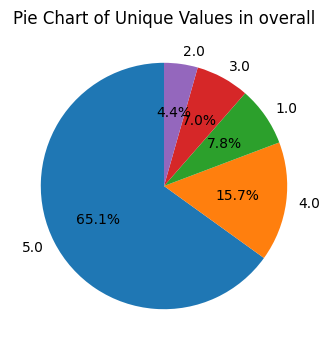

In [55]:
value_counts = df[column_name].value_counts()

plt.figure(figsize=(8, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
plt.title("Pie Chart of Unique Values in " + column_name)
plt.ylabel("")  # To remove the default ylabel
plt.show()

Given the substantial prevalence of 5-star ratings in the dataset, there was a concern that interpreting the true predictive capability of the model solely based on accuracy might be challenging. To address this, we opted to resample the dataframe, aiming to increase the representation of records with star ratings less than 5.

To perform the sampling, we assigned greater weights to records with star ratings less than 5.

In [56]:
df['Weights'] = np.where(df['overall'] < 5, .75, .25)
df['Weights'].unique()

array([0.25, 0.75])

When sampling with these weights, the distribution of star ratings became more normalized, with approximately 40% having a 5-star rating. To expedite the training process, I limited the sample size to 10,000 rows. Additionally, we removed any records with missing values in the Review and Ratings columns.

In [57]:
sample = df.sample(n = sample_size, random_state = 10, weights = 'Weights')

sample = sample.dropna(how = 'any', subset = ['reviewText', 'overall'])

In [58]:
sample.overall.value_counts(normalize = True)

overall
5.0    0.380566
4.0    0.279596
1.0    0.138597
3.0    0.122886
2.0    0.078355
Name: proportion, dtype: float64

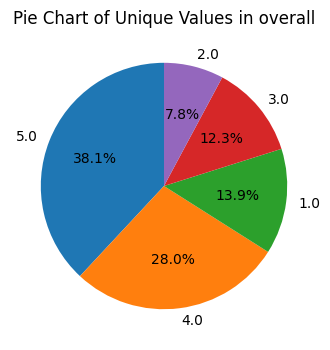

In [59]:
value_counts = sample[column_name].value_counts()

plt.figure(figsize=(8, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
plt.title("Pie Chart of Unique Values in " + column_name)
plt.ylabel("")  # To remove the default ylabel
plt.show()

Dataset View

In [60]:
sample.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Weights
1176440,1176440,3.0,4.0,True,"01 28, 2013",A36DVY5LICK8QE,B001IPSX8M,NaN,S. Fox,I purchased this to replace a Behringer USB au...,The Gain Control is Not A Gain Control,1359331200,NaN,0.75
31959,31959,5.0,NaN,True,"04 23, 2015",A152ZMO9ZM0U9I,B0002CZSJO,{'Color:': ' Black'},Darren,It holds down the strings on the guitar perfec...,It is easy to put on and take off,1429747200,NaN,0.25
969023,969023,5.0,NaN,True,"08 8, 2016",A1KCY05PM39OJH,B013LG9WQM,{'Size:': ' 41L x 16W x 6D 61 - 76 keys'},NAR.H,High Quality Cover. Fits my Korg PA900. Adjust...,Highly recommended.,1470614400,NaN,0.25
1143215,1143215,5.0,NaN,True,"09 7, 2017",A2VNM3MNUS263A,B000S7268E,NaN,Willie P,Great quality cables! No noise and excellent ...,Great quality cables,1504742400,NaN,0.25
759324,759324,4.0,NaN,True,"11 24, 2015",A2QUAXLLMZGZTA,B00GW1DFY4,NaN,Kirsten R.,Giving it 4 stars because the 1st hole seems t...,"Durable, affordable, in tune.",1448323200,NaN,0.75


## Text Preprocessing

In [61]:
sample.dtypes

Unnamed: 0          int64
overall           float64
vote               object
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
image              object
Weights           float64
dtype: object

I transformed the star rating column from integer to string to ensure proper input for subsequent modeling.

In [62]:
sample['overall'] = sample['overall'].astype(str)

In [63]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yashvipipaliya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashvipipaliya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashvipipaliya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Next we roceeded to tokenize the words in the review text of each record.

In [64]:
from nltk import word_tokenize

tokens = [word_tokenize(sen) for sen in sample.reviewText]


After tokenizing the words in the review text, we proceeded to remove all stop words from the resulting tokenized word list, including common words like "the" and "and".


In [65]:
from nltk.corpus import stopwords

stoplist = stopwords.words('english')

def removeStopWords(tokens):
    lowercase_tokens = [word.lower() for word in tokens]
    lowercase_stoplist = set(stopword.lower() for stopword in stoplist)
    return [word for word in lowercase_tokens if word not in lowercase_stoplist]

filtered_words = [removeStopWords(sen) for sen in tokens]

sample['raw_tokens'] = filtered_words #concat the dataframes

In [66]:
print(stoplist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The raw_tokens column below provides a snapshot of tokens after removing stop words

In [67]:
sample.head(5)

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Weights,raw_tokens
1176440,1176440,3.0,4.0,True,"01 28, 2013",A36DVY5LICK8QE,B001IPSX8M,NaN,S. Fox,I purchased this to replace a Behringer USB au...,The Gain Control is Not A Gain Control,1359331200,NaN,0.75,"[purchased, replace, behringer, usb, audio, in..."
31959,31959,5.0,NaN,True,"04 23, 2015",A152ZMO9ZM0U9I,B0002CZSJO,{'Color:': ' Black'},Darren,It holds down the strings on the guitar perfec...,It is easy to put on and take off,1429747200,NaN,0.25,"[holds, strings, guitar, perfectly, ., easy, p..."
969023,969023,5.0,NaN,True,"08 8, 2016",A1KCY05PM39OJH,B013LG9WQM,{'Size:': ' 41L x 16W x 6D 61 - 76 keys'},NAR.H,High Quality Cover. Fits my Korg PA900. Adjust...,Highly recommended.,1470614400,NaN,0.25,"[high, quality, cover, ., fits, korg, pa900, ...."
1143215,1143215,5.0,NaN,True,"09 7, 2017",A2VNM3MNUS263A,B000S7268E,NaN,Willie P,Great quality cables! No noise and excellent ...,Great quality cables,1504742400,NaN,0.25,"[great, quality, cables, !, noise, excellent, ..."
759324,759324,4.0,NaN,True,"11 24, 2015",A2QUAXLLMZGZTA,B00GW1DFY4,NaN,Kirsten R.,Giving it 4 stars because the 1st hole seems t...,"Durable, affordable, in tune.",1448323200,NaN,0.75,"[giving, 4, stars, 1st, hole, seems, leak, air..."


the data normalization process involved removing non-ASCII characters, converting text to lowercase, eliminating punctuation marks, and replacing numbers with words

In [68]:

import re, string, unicodedata
import inflect
from nltk.corpus import stopwords

def remove_non_ascii(words):
    """Eliminate non-ASCII characters from a list of tokenized words."""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
    

def to_lowercase(words):
    """Transform all characters to lowercase in a list of tokenized words."""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

#remove all punctuation marks
def remove_punctuation(words):
    """Eliminate punctuation from a list of tokenized words."""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Substitute all integer occurrences in a list of tokenized words with their textual representation."""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words


def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words


The functions were implemented on each record within the sampled dataframe. The resultant normalized tokens are displayed in the "tokens" column below

In [69]:
sample['tokens'] = sample['raw_tokens'].apply(lambda x: normalize(x))
sample.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Weights,raw_tokens,tokens
1176440,1176440,3.0,4.0,True,"01 28, 2013",A36DVY5LICK8QE,B001IPSX8M,NaN,S. Fox,I purchased this to replace a Behringer USB au...,The Gain Control is Not A Gain Control,1359331200,NaN,0.75,"[purchased, replace, behringer, usb, audio, in...","[purchased, replace, behringer, usb, audio, in..."
31959,31959,5.0,NaN,True,"04 23, 2015",A152ZMO9ZM0U9I,B0002CZSJO,{'Color:': ' Black'},Darren,It holds down the strings on the guitar perfec...,It is easy to put on and take off,1429747200,NaN,0.25,"[holds, strings, guitar, perfectly, ., easy, p...","[holds, strings, guitar, perfectly, easy, put,..."
969023,969023,5.0,NaN,True,"08 8, 2016",A1KCY05PM39OJH,B013LG9WQM,{'Size:': ' 41L x 16W x 6D 61 - 76 keys'},NAR.H,High Quality Cover. Fits my Korg PA900. Adjust...,Highly recommended.,1470614400,NaN,0.25,"[high, quality, cover, ., fits, korg, pa900, ....","[high, quality, cover, fits, korg, pa900, adju..."
1143215,1143215,5.0,NaN,True,"09 7, 2017",A2VNM3MNUS263A,B000S7268E,NaN,Willie P,Great quality cables! No noise and excellent ...,Great quality cables,1504742400,NaN,0.25,"[great, quality, cables, !, noise, excellent, ...","[great, quality, cables, noise, excellent, dur..."
759324,759324,4.0,NaN,True,"11 24, 2015",A2QUAXLLMZGZTA,B00GW1DFY4,NaN,Kirsten R.,Giving it 4 stars because the 1st hole seems t...,"Durable, affordable, in tune.",1448323200,NaN,0.75,"[giving, 4, stars, 1st, hole, seems, leak, air...","[giving, four, stars, 1st, hole, seems, leak, ..."


Finally, we applied stemming to each of the tokenized words using Lemmatization, which is a form of stemming technique. These transformations were executed on the same "tokens" column mentioned earlier.

In [70]:
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def lemmatize_verbs(words):
    """Perform lemmatization on verbs in the list of tokenized words."""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [71]:
sample.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Weights,raw_tokens,tokens
1176440,1176440,3.0,4.0,True,"01 28, 2013",A36DVY5LICK8QE,B001IPSX8M,NaN,S. Fox,I purchased this to replace a Behringer USB au...,The Gain Control is Not A Gain Control,1359331200,NaN,0.75,"[purchased, replace, behringer, usb, audio, in...","[purchased, replace, behringer, usb, audio, in..."
31959,31959,5.0,NaN,True,"04 23, 2015",A152ZMO9ZM0U9I,B0002CZSJO,{'Color:': ' Black'},Darren,It holds down the strings on the guitar perfec...,It is easy to put on and take off,1429747200,NaN,0.25,"[holds, strings, guitar, perfectly, ., easy, p...","[holds, strings, guitar, perfectly, easy, put,..."
969023,969023,5.0,NaN,True,"08 8, 2016",A1KCY05PM39OJH,B013LG9WQM,{'Size:': ' 41L x 16W x 6D 61 - 76 keys'},NAR.H,High Quality Cover. Fits my Korg PA900. Adjust...,Highly recommended.,1470614400,NaN,0.25,"[high, quality, cover, ., fits, korg, pa900, ....","[high, quality, cover, fits, korg, pa900, adju..."
1143215,1143215,5.0,NaN,True,"09 7, 2017",A2VNM3MNUS263A,B000S7268E,NaN,Willie P,Great quality cables! No noise and excellent ...,Great quality cables,1504742400,NaN,0.25,"[great, quality, cables, !, noise, excellent, ...","[great, quality, cables, noise, excellent, dur..."
759324,759324,4.0,NaN,True,"11 24, 2015",A2QUAXLLMZGZTA,B00GW1DFY4,NaN,Kirsten R.,Giving it 4 stars because the 1st hole seems t...,"Durable, affordable, in tune.",1448323200,NaN,0.75,"[giving, 4, stars, 1st, hole, seems, leak, air...","[giving, four, stars, 1st, hole, seems, leak, ..."


In [72]:
sample['tokens'] = sample['tokens'].apply(lambda x: lemmatize_verbs(x))

The following cells depict the progression of tokenization and preprocessing for a sample review.

In [73]:
print(len(sample))
print(sample['reviewText'].iloc[105])

9993
Well made, very convenient, fits great, comfortable, very adjustable.


The tokenized version, after removing stopwords, is presented below.

In [74]:
print(sample['raw_tokens'].iloc[105])

['well', 'made', ',', 'convenient', ',', 'fits', 'great', ',', 'comfortable', ',', 'adjustable', '.']


The tokens, after complete normalization, are displayed below.

In [75]:
print(sample['tokens'].iloc[105])

['well', 'make', 'convenient', 'fit', 'great', 'comfortable', 'adjustable']


In [76]:
freq_words = sample.tokens.str.split(expand = True).stack().value_counts()
freq_words

Series([], Name: count, dtype: int64)

### Word Clouds for Distribution of Words

The function below performs filtering on the sampled dataframe using a specified star rating (e.g., '1.0'). Subsequently, it generates a list that concatenates all normalized tokens from across all records.

In [77]:
def text_per_rating(rating):
    sample_rating = sample[sample['overall'] == rating]
    text_list = sample_rating['tokens'].tolist() 
    text_list = list([a for b in text_list for a in b])
    text_list = ' '.join(map(str, text_list)) 
    return text_list

From this list, the following function counts the frequency of the top 10 words for each specified star rating.

In [78]:
from collections import Counter

def freq(rating):
    str_list = text_per_rating(rating)
    str_list = str_list.split()
#     unique_words = set(str_list)
    counts = Counter(str_list)
    counts = counts.most_common(10)
    return counts

In [79]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image

def plot_word_clouds(rating):
    text_list = text_per_rating(rating)
    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["album", "song", "cd", "music", "songs"])

    # text_cloud = sample.reviewText
    text_cloud = str(text_list)
    wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(text_cloud)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title('Word cloud for {} star rating'.format(rating))
    plt.axis("off")
    plt.show()

Word cloud for Rating 1

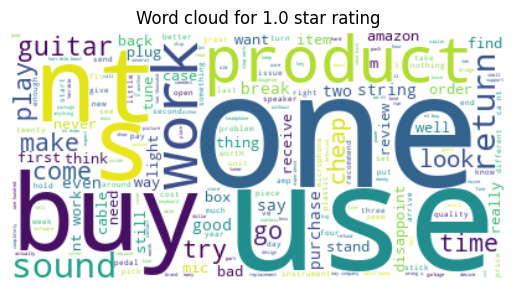

In [80]:
plot_word_clouds('1.0')

In [33]:
freq('1.0')

[('nt', 712),
 ('one', 524),
 ('work', 494),
 ('get', 476),
 ('buy', 426),
 ('use', 381),
 ('would', 333),
 ('s', 331),
 ('product', 285),
 ('sound', 270)]

Word cloud for Rating 2

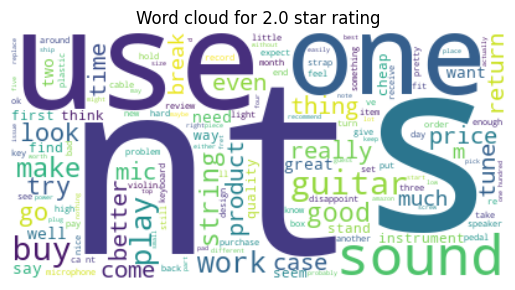

In [34]:
plot_word_clouds('2.0')

In [35]:
freq('2.0')

[('nt', 521),
 ('s', 321),
 ('get', 311),
 ('one', 303),
 ('sound', 301),
 ('use', 269),
 ('would', 237),
 ('work', 236),
 ('like', 204),
 ('guitar', 188)]

Word cloud for Rating 3

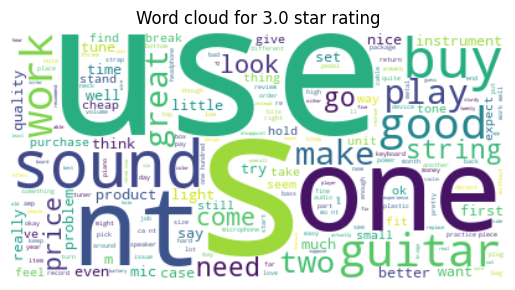

In [36]:
plot_word_clouds('3.0')

In [37]:
freq('3.0')

[('nt', 625),
 ('s', 502),
 ('one', 475),
 ('use', 449),
 ('sound', 431),
 ('get', 413),
 ('work', 399),
 ('good', 352),
 ('like', 309),
 ('would', 299)]

Word cloud for Rating 4

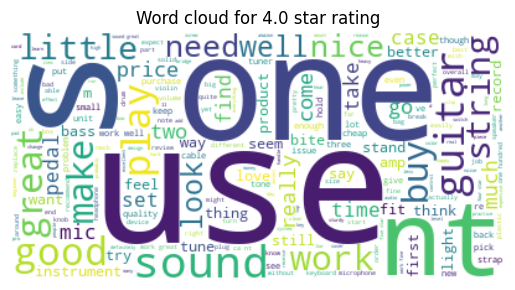

In [38]:
plot_word_clouds('4.0')

In [39]:
freq('4.0')

[('nt', 1250),
 ('sound', 1154),
 ('use', 1105),
 ('s', 1099),
 ('good', 1084),
 ('great', 1031),
 ('one', 920),
 ('work', 909),
 ('get', 865),
 ('like', 761)]

Word cloud for Rating 5

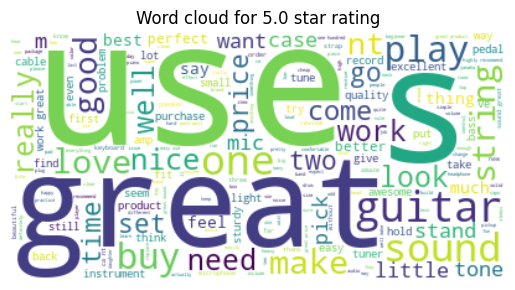

In [40]:
plot_word_clouds('5.0')

In [41]:
freq('5.0')

[('great', 1501),
 ('sound', 1123),
 ('use', 1121),
 ('s', 901),
 ('nt', 887),
 ('one', 885),
 ('good', 811),
 ('work', 787),
 ('guitar', 760),
 ('get', 733)]

As seen from the word clouds and frequencies above, there is a very similar distribution of common words across all star ratings. Even among 1 star ratings, words like "good", "great", and "love" were still very common. However, it's possible these sentiments were negated with preceeding words like 'not good'.

# Model Implementation

### Bag of Words

Using the Bag-of-Words (BOW) method, a matrix of vectors is generated to depict the frequency of each word. Each vector corresponds to a review, and the length of each vector corresponds to the total count of distinct words present in the entire corpus across all records.

## SVM Model

Split training and test data

In [81]:
print(sample['tokens'].iloc[221])

['s', 'great', 'guitar', 'price', 'pay', 'nineteen thousand, five hundred', 'floyd', 'rise', 'one', 'string', 'change', 'strip', 'screw', 'whammy', 'bar', 'loose', 'tighten', 'actual', 'guitar', 'great', 'action', 'good', 'pickups', 'good', 'neck', 'good', 'finish', 'beautiful', 'floyd', 'absolute', 'crap', 'd', 'still', 'recommend', 'guitar', 'price', 'pay']


In [82]:
from sklearn.model_selection import train_test_split

sentences = sample['tokens'].str.join(' ') ## join values into string
y = sample['overall'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=42)

In [84]:
sentences_train.iloc[994]

'string break day three guitar package nicely light weight nine year old string nt sturdy sure take replace string'

Vectorize the training and testing data

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

Train the model

In [46]:
from sklearn.svm import SVC

from datetime import datetime
start_time = datetime.now()

classifier_svc = SVC()
classifier_svc.fit(X_train, y_train)
score = classifier_svc.score(X_test, y_test)
score_train = classifier_svc.score(X_train, y_train)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:17.672414


Accuracy of the SVM model is printed below.

In [47]:
print("Training Accuracy:", score_train)
print("Testing Accuracy:", score) 

Training Accuracy: 0.7215411558669002
Testing Accuracy: 0.5177588794397199


['classifier_svc.pkl']

In [50]:
score = classifier_svc.score(X_test, y_test)
print("Accuracy:", score) #print accuracy of SVM model

Accuracy: 0.5177588794397199


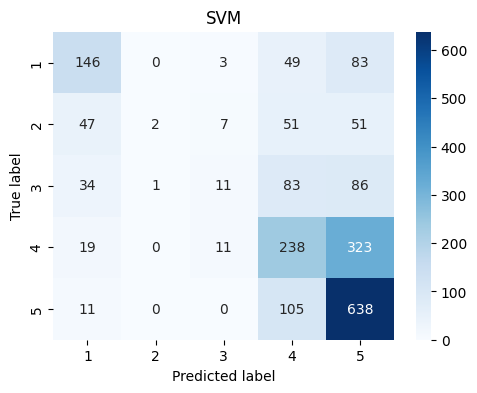

Accuracy: 0.5177588794397199


In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = classifier_svc.predict(X_test)

# Creates a confusion matrix
cm = confusion_matrix(y_test, predictions) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')

plt.title("SVM")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.ticklabel_format(style = 'plain', axis = 'y', useOffset = False)
plt.show()
score = classifier_svc.score(X_test, y_test)
print("Accuracy:", score) #print accuracy of SVM model

In [53]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

The output presented below displays additional performance metrics for the SVM model. It is evident that the F1 score is relatively low, reflecting the balance between precision and recall. This analysis was conducted for all subsequent models as well.

In [54]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.57      0.52      0.54       281
         2.0       0.67      0.01      0.02       158
         3.0       0.34      0.05      0.09       215
         4.0       0.45      0.40      0.43       591
         5.0       0.54      0.85      0.66       754

    accuracy                           0.52      1999
   macro avg       0.51      0.37      0.35      1999
weighted avg       0.51      0.52      0.46      1999



In [55]:
pred_stars = predictions.tolist()
# pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

['5.0', '4.0', '5.0', '5.0']

In [56]:
test_indexes = sentences_test.index
# sample.iloc[test_indexes]
# sample.iloc[[5441],:]

A crucial performance metric that I aimed to assess was the proximity of my star rating predictions to the actual ratings. The dataframe provided below records the absolute difference between the actual and predicted ratings in the "diff_pred" column. This snapshot of the dataframe focuses on the records with the most significant difference between prediction and rating, representing the worst-performing instances. A similar analysis was conducted for all subsequent models.

In [57]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(pd.to_numeric(sample_df_test['pred_stars']) - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(-10)

,overall,reviewText,tokens,pred_stars,diff_pred
805797,1.0,utterly useless,"[utterly, useless]",5.0,4.0
355684,5.0,I have an old PSR-32 keyboard which came standard with Yamaha's PA-4 adapter (which I fried in t...,"[old, psr32, keyboard, come, standard, yamaha, s, pa4, adapter, fry, early, ninety, s, yamaha, r...",1.0,4.0
815290,1.0,Missing power cord. Missing part of the stand.,"[miss, power, cord, miss, part, stand]",5.0,4.0
981033,1.0,"Plays only one note at a time, and only on the keys that work.","[play, one, note, time, key, work]",5.0,4.0
1041238,1.0,software sucks,"[software, suck]",5.0,4.0
...,...,...,...,...,...
506494,1.0,Guitar broke after 3 weeks of use. Bridge came off of the guitar.,"[guitar, break, three, weeks, use, bridge, come, guitar]",1.0,0.0
1460366,5.0,great sound,"[great, sound]",5.0,0.0
626336,5.0,I have these and a pair of Sennheiser HD800's. Also have a pair of B&W PM-1's. I use the Senn's ...,"[pair, sennheiser, hd800, s, also, pair, b, w, pm1, s, use, senn, s, day, slightly, less, colour...",5.0,0.0
516625,4.0,Awesome mini delay pedal. Sure you won't get all the functionality of its larger brethren but yo...,"[awesome, mini, delay, pedal, sure, wo, nt, get, functionality, larger, brethren, wo, nt, find, ...",4.0,0.0


Moreover, I generated the frequency distribution of differences in star predictions. As illustrated below, the majority of predictions were either accurate or within a 1-star rating difference. This identical analysis was conducted for all subsequent models.

In [58]:

sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1035
1.0     577
2.0     174
3.0     119
4.0      94
dtype: int64

## Simple Neural Net

For labeled data, transform the potential star values ranging from 1 to 5 into individual columns.

In [86]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Y = sample['overall'].values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

dummy_Y = to_categorical(encoded_Y)

/Users/yashvipipaliya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


On the revised dataset, redistribute the records into training and validation datasets.

In [87]:
from sklearn.model_selection import train_test_split

# sentences = sample['Text_Final'].values
sentences = sample['tokens'].str.join(' ') ## join values into string
#y = sample['overall'].values
y = dummy_Y# use encoded labels for y

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.20, random_state=42)

Generate a sparse matrix representing the input vectors.

In [88]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)


In [89]:
from keras.models import Sequential
from keras import layers


input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(16, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.4)) ##added dropout layer
model.add(layers.Dense(5, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                441248    
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 85        
                                                                 
Total params: 441861 (1.69 MB)
Trainable params: 441861 (1.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train Model

In [63]:
from keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['accuracy'])



In [64]:
start_time = datetime.now()

nn_bow = model.fit(X_train, y_train,
epochs=25,
verbose=1,
validation_data=(X_test, y_test),
batch_size = 15)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train

Epoch 1/25
533/533 [==============================] - 1s 1ms/step - loss: 1.5742 - accuracy: 0.3344 - val_loss: 1.5191 - val_accuracy: 0.4167
Epoch 2/25
533/533 [==============================] - 0s 921us/step - loss: 1.4847 - accuracy: 0.3870 - val_loss: 1.4290 - val_accuracy: 0.4332
Epoch 3/25
533/533 [==============================] - 0s 877us/step - loss: 1.4065 - accuracy: 0.4256 - val_loss: 1.3606 - val_accuracy: 0.4597
Epoch 4/25
533/533 [==============================] - 0s 876us/step - loss: 1.3406 - accuracy: 0.4597 - val_loss: 1.3061 - val_accuracy: 0.4842
Epoch 5/25
533/533 [==============================] - 1s 1ms/step - loss: 1.2885 - accuracy: 0.4827 - val_loss: 1.2670 - val_accuracy: 0.4982
Epoch 6/25
533/533 [==============================] - 0s 871us/step - loss: 1.2380 - accuracy: 0.5058 - val_loss: 1.2354 - val_accuracy: 0.5068
Epoch 7/25
533/533 [==============================] - 0s 854us/step - loss: 1.1948 - accuracy: 0.5290 - val_loss: 1.2116 - val_accuracy: 0.5

In [65]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7402
Testing Accuracy:  0.5583


In [111]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(nn_bow):
    acc = nn_bow.history['accuracy']
    val_acc = nn_bow.history['val_accuracy']
    loss = nn_bow.history['loss']
    val_loss = nn_bow.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


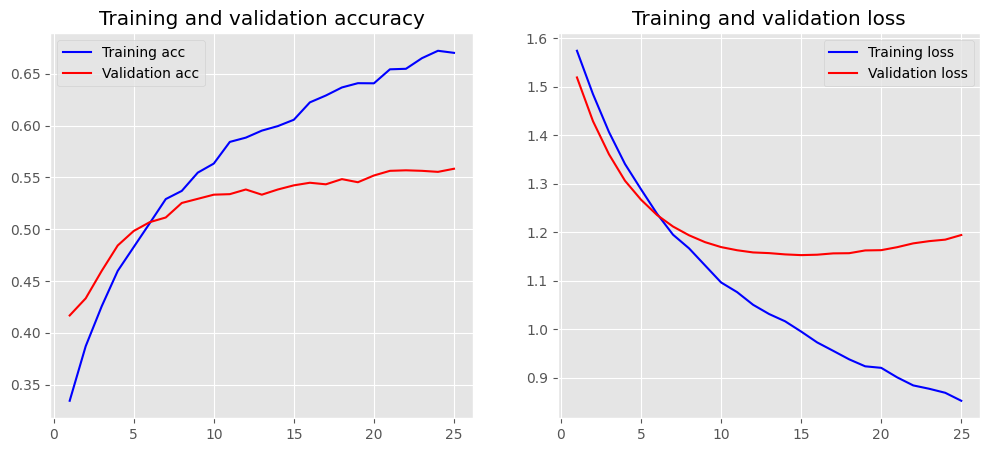

In [67]:
plot_history(nn_bow)

In [68]:
loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

Training Accuracy: 0.7402
Testing Accuracy:  0.5583


63/63 [==============================] - 0s 383us/step


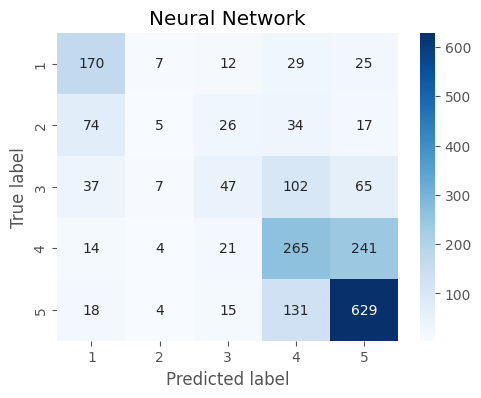

Training Accuracy: 0.7402
Testing Accuracy:  0.5583


In [69]:
import seaborn as sns

predictions = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
plt.title("Neural Network")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

In [70]:
from keras import backend as K

def recall_m(y_test, predictions):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * predictions, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_test, predictions):
    precision = precision_m(y_test, predictions)
    recall = recall_m(y_test, predictions)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [71]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

32/32 [==============================] - 0s 610us/step
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       243
           1       0.19      0.03      0.05       156
           2       0.39      0.18      0.25       258
           3       0.47      0.49      0.48       545
           4       0.64      0.79      0.71       797

    accuracy                           0.56      1999
   macro avg       0.45      0.44      0.42      1999
weighted avg       0.52      0.56      0.52      1999



In [72]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[4, 5, 5, 5]

In [73]:
test_indexes = sentences_test.index

In [74]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
1419040,1.0,The overall length is listed as 29 3/4\n\nThe actual measurement is 30 1/2\n\nThis error has mad...,"[overall, length, list, twenty-nine, thirty-four, actual, measurement, thirty, twelve, error, ma...",4,3.0
736037,4.0,"Superb sound, not too much bass though.","[superb, sound, much, bass, though]",5,1.0
922832,5.0,"Love the versitilty of this keyboard. I write songs for school. It prints, erases, reorganizes, ...","[love, versitilty, keyboard, write, songs, school, print, erase, reorganize, play, like, regular...",5,0.0
265877,5.0,Great for playing concerts outdoors!,"[great, play, concert, outdoors]",5,0.0
355348,5.0,"It's small, durable, straight to the point, I still use this badboy every day. I have zero compl...","[s, small, durable, straight, point, still, use, badboy, every, day, zero, complaints, sexy, box...",5,0.0
1397814,5.0,"I tried several ""named brands"" that just use normal cable ends... The name brands are being toss...","[try, several, name, brand, use, normal, cable, end, name, brand, toss, longer, trust, two, fail...",1,4.0
260380,1.0,CAN SOMEONE HELP ME! I just got this light for Christmas and when i plugged it in the light did ...,"[someone, help, get, light, christmas, plug, light, turn, light, bulbs, rotate, plug, light, emi...",1,0.0
1380145,5.0,Great!,[great],5,0.0
15678,5.0,Great mic!,"[great, mic]",5,0.0
1151670,4.0,"Great reed, but a little too hard for my mouthpiece. I like the 3.5 better overall.","[great, reed, little, hard, mouthpiece, like, thirty-five, better, overall]",4,0.0


In [75]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1116
1.0     609
2.0     167
3.0      64
4.0      43
dtype: int64

## Word Embedding

There are three primary methods for embedding:

- Representing words by each word as a vector.
- Representing characters by each character as a vector.
- Representing N-grams of words/characters as a vector, where N-grams are overlapping groups of multiple succeeding words/characters in the text.

For this project, I'll be using method #1. Two common approaches to achieve this are through one-hot encoding and word embeddings.

### One-hot encoding

In [90]:
Y = sample['overall'].values
encoder = LabelEncoder()
encoder.fit(Y)
star_labels = encoder.fit_transform(Y)
star_labels

array([2, 4, 4, ..., 0, 4, 1])

In [91]:
from sklearn.preprocessing import OneHotEncoder

len_star = len(star_labels)
encoder = OneHotEncoder()
star_labels = star_labels.reshape((len_star, 1))
encoder.fit_transform(star_labels)

<9993x5 sparse matrix of type '<class 'numpy.float64'>'
	with 9993 stored elements in Compressed Sparse Row format>

In [92]:
sentences_train.iloc[2]

'like crash lot china mount make china move around much get away'

In [93]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000) 
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index)+1  

print(sentences_train.iloc[221]) 
print(X_train[2]) 
len(X_train[2])

buy microphone saw ca prop65 warn product contain chemicals know state california cause cancer birth defect reproductive harm ca prop65 warn mention list see d like money back ca nt return nothing like speak cancer d like money back
[10, 1000, 88, 1015, 225, 15, 1015, 280, 92, 30, 7, 221]


12

Find index of sample words

In [94]:
for word in ['good', 'bad', 'terrible']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

good: 9
bad: 121
terrible: 537


Obtain most frequent words

In [95]:
tokens_list = list(tokenizer.word_index)
tokens_list[0:10]

['nt', 'use', 'sound', 'one', 's', 'great', 'get', 'work', 'good', 'like']

### Padding

In [96]:
maxlen = max([len(listElem.split()) for listElem in sentences]) 

In [97]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0:5, :])

[[  17   29   20 ...    0    0    0]
 [  23   16  146 ...    0    0    0]
 [  10 1000   88 ...    0    0    0]
 [3682 1649  281 ...    0    0    0]
 [   6  711  363 ...    0    0    0]]


In [98]:
from keras.models import Sequential
from keras import layers

embedding_dim = 10

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.40))
model.add(layers.Dense(5, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2103, 10)          138330    
                                                                 
 flatten (Flatten)           (None, 21030)             0         
                                                                 
 dense_3 (Dense)             (None, 32)                672992    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 811487 (3.10 MB)
Trainable params: 811487 (3.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
start_time = datetime.now()

nn_embed = model.fit(X_train, y_train,
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=15)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/25
533/533 [==============================] - 2s 3ms/step - loss: 1.4796 - accuracy: 0.3648 - val_loss: 1.3600 - val_accuracy: 0.3987
Epoch 2/25
533/533 [==============================] - 1s 2ms/step - loss: 1.3302 - accuracy: 0.4179 - val_loss: 1.2211 - val_accuracy: 0.4722
Epoch 3/25
533/533 [==============================] - 1s 2ms/step - loss: 1.1638 - accuracy: 0.5044 - val_loss: 1.1817 - val_accuracy: 0.4872
Epoch 4/25
533/533 [==============================] - 1s 2ms/step - loss: 1.0478 - accuracy: 0.5482 - val_loss: 1.1790 - val_accuracy: 0.4967
Epoch 5/25
533/533 [==============================] - 1s 2ms/step - loss: 0.9695 - accuracy: 0.5881 - val_loss: 1.2285 - val_accuracy: 0.4912
Epoch 6/25
533/533 [==============================] - 1s 3ms/step - loss: 0.8764 - accuracy: 0.6316 - val_loss: 1.2536 - val_accuracy: 0.4997
Epoch 7/25
533/533 [==============================] - 2s 4ms/step - loss: 0.7790 - accuracy: 0.6849 - val_loss: 1.3330 - val_accuracy: 0.5023
Epoch 

In [85]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9602
Testing Accuracy:  0.4702


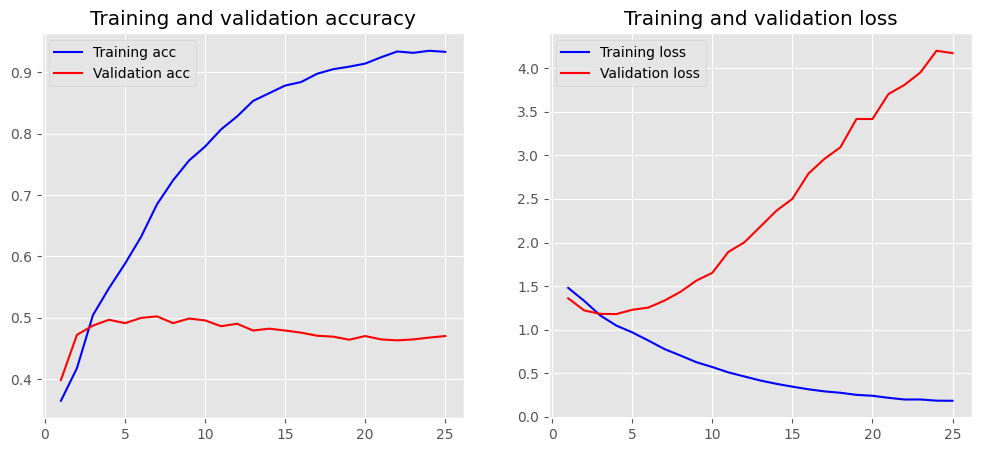

In [86]:
plot_history(nn_embed)

63/63 [==============================] - 0s 914us/step


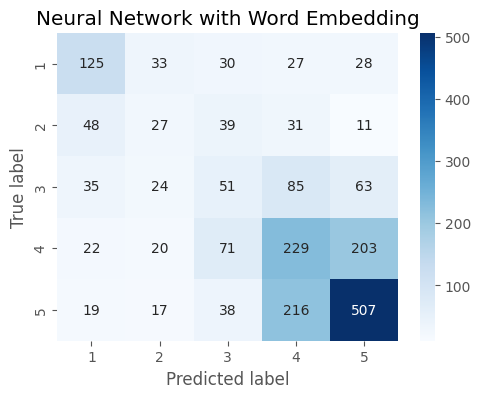

Training Accuracy: 0.9602
Testing Accuracy:  0.4702


In [87]:
import seaborn as sns
predictions = model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')

plt.title("Neural Network with Word Embedding")
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [88]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       243
           1       0.22      0.17      0.19       156
           2       0.22      0.20      0.21       258
           3       0.39      0.42      0.40       545
           4       0.62      0.64      0.63       797

    accuracy                           0.47      1999
   macro avg       0.39      0.39      0.39      1999
weighted avg       0.46      0.47      0.47      1999



In [89]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]

[3, 4, 5, 5]

In [90]:
test_indexes = sentences_test.index

In [91]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(-10)

,overall,reviewText,tokens,pred_stars,diff_pred
535637,5.0,We have 2 types of tuners. This one is the easiest to use and we all fight over it.,"[two, type, tuners, one, easiest, use, fight]",1,4.0
40614,1.0,Still getting issues with neighbors after installing this foam around my entertainment center ar...,"[still, get, issue, neighbor, instal, foam, around, entertainment, center, area, hold, back, bas...",5,4.0
1463576,1.0,The belt sent is too big and does not fit.,"[belt, send, big, fit]",5,4.0
233840,5.0,"Works well, surprisingly solid construction for $29. Had bad experience playing live recently, c...","[work, well, surprisingly, solid, construction, twenty-nine, bad, experience, play, live, recent...",1,4.0
922786,1.0,There is a delay of two seconds between pressing a key and hearing a sound. Pressing keys feels ...,"[delay, two, second, press, key, hear, sound, press, key, feel, odd, user, guide, confuse]",5,4.0
...,...,...,...,...,...
969283,5.0,Love it!,[love],5,0.0
1112418,4.0,"Pickguard set consists of two ""stripes"" - wider one for applying under soundhole and narrower on...","[pickguard, set, consist, two, strip, wider, one, apply, soundhole, narrower, one, apply, soundh...",4,0.0
272424,5.0,"This is a very solid piece of equipment. Inexpensive, small, made well and works well.\n\nSave s...","[solid, piece, equipment, inexpensive, small, make, well, work, well, save, money, get, one]",5,0.0
1015787,1.0,The battery on this piano is used up so quick! Why give me a charger with the piano if it doesnt...,"[battery, piano, use, quick, give, charger, piano, doesnt, charge, piano, literally, include, ch...",1,0.0


In [92]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    939
1.0    719
2.0    217
3.0     77
4.0     47
dtype: int64

## CNN

In [215]:
embedding_dim = 75

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 2103, 75)          1504875   
                                                                 
 conv1d_4 (Conv1D)           (None, 2102, 64)          9664      
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_51 (Dense)            (None, 10)                650       
                                                                 
 dense_52 (Dense)            (None, 5)                 55        
                                                                 
Total params: 1515244 (5.78 MB)
Trainable params: 1515244 (5.78 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [216]:
start_time = datetime.now()

cnn_model = model.fit(X_train, y_train,
                    epochs=2,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=64)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time)) #print out how long it took for model to train


Epoch 1/2
250/250 [==============================] - 16s 64ms/step - loss: 1.3454 - accuracy: 0.4313 - val_loss: 1.1497 - val_accuracy: 0.5373
Epoch 2/2
250/250 [==============================] - 15s 60ms/step - loss: 1.0619 - accuracy: 0.5609 - val_loss: 1.0872 - val_accuracy: 0.5548
Duration: 0:00:31.495358


In [217]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.6149
Testing Accuracy:  0.5548


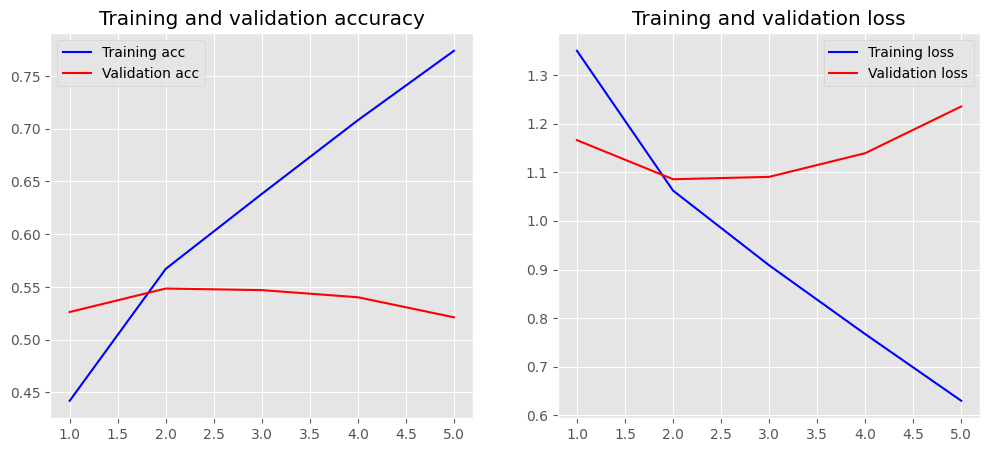

In [210]:
plot_history(cnn_model)

https://stackoverflow.com/questions/50920908/get-confusion-matrix-from-a-keras-multiclass-model

125/125 [==============================] - 1s 10ms/step


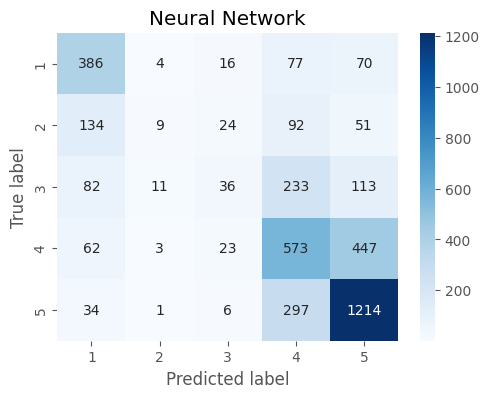

Training Accuracy: 0.6149
Testing Accuracy:  0.5548


In [218]:
import seaborn as sns

predictions = model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')

plt.title("Neural Network")
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

In [212]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]
test_indexes = sentences_test.index

In [220]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

63/63 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.55      0.70      0.62       553
           1       0.32      0.03      0.05       310
           2       0.34      0.08      0.12       475
           3       0.45      0.52      0.48      1108
           4       0.64      0.78      0.70      1552

    accuracy                           0.55      3998
   macro avg       0.46      0.42      0.40      3998
weighted avg       0.52      0.55      0.51      3998



In [219]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
1235992,4.0,I bought this light to replace an old style mirror ball. I shelled out the extra hundred bucks ...,"[buy, light, replace, old, style, mirror, ball, shell, extra, hundred, buck, get, triled, vs, wh...",3,1.0
851203,4.0,This instrument came in good condition and earlier than expected (which is always a plus). It's ...,"[instrument, come, good, condition, earlier, expect, always, plus, s, build, quality, solid, con...",4,0.0
814619,2.0,It's broken. It intermittently fails. The A key below middle C sounds weak. Only the first in...,"[s, break, intermittently, fail, key, middle, c, sound, weak, first, instrument, stereo, piano, ...",1,1.0
798435,5.0,Jazz picks are not for eveyone<\nI do think everyone should give em a try though\na real attempt...,"[jazz, pick, eveyone, think, everyone, give, em, try, though, real, attempt, love, dunlops, grea...",4,1.0
607162,5.0,I purchased this flute for my 9-year-old daughter who was starting beginning band. It was much c...,"[purchase, flute, 9yearold, daughter, start, begin, band, much, cheaper, big, name, model, new, ...",4,1.0
499540,1.0,"Could not get any sound out of it, tried with an iRig to make sure cables weren't bad. Even chan...","[could, get, sound, try, irig, make, sure, cable, nt, bad, even, change, battery, still, sound, ...",1,0.0
130164,3.0,"I'm not a fiddle player, my wife is. I bought these Helicore strings and the Non-whistling 1st ...","[m, fiddle, player, wife, buy, helicore, string, nonwhistling, 1st, acquire, one hundred, year, ...",2,1.0
234764,3.0,"I received the bag today. After removing the packing, I inspected the bag. While trying to lengt...","[receive, bag, today, remove, pack, inspect, bag, try, lengthen, shoulder, strap, stitch, comple...",5,2.0
1028233,5.0,"Bought for my daughter and her first guitar, she loves it! Opens and closes great, apparently do...","[buy, daughter, first, guitar, love, open, close, great, apparently, s, suppose, look, really, n...",5,0.0
224037,4.0,I needed a battery powered amp so I could jam with some buddies of mine at work during lunch out...,"[need, battery, power, amp, could, jam, buddies, mine, work, lunch, park, lot, read, positive, r...",3,1.0


In [214]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    2084
1.0    1341
2.0     333
3.0     162
4.0      78
dtype: int64

## RNN

In [119]:
  
rnn = Sequential(name="Simple_RNN")
rnn.add(layers.Embedding(len(tokenizer.word_index)+1,
                        10,
                        input_length=maxlen))
 
rnn.add(layers.SimpleRNN(64,activation='relu',return_sequences=True))
 
rnn.add(layers.SimpleRNN(32,activation='relu',return_sequences=False))
 
rnn.add(layers.Dense(5, activation='softmax'))
rnn.compile(
	loss="categorical_crossentropy",
	optimizer='adam',
	metrics=['accuracy']
) 
print(rnn.summary())

Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 2103, 10)          138330    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 2103, 64)          4800      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_11 (Dense)            (None, 5)                 165       
                                                                 
Total params: 146399 (571.87 KB)
Trainable params: 146399 (571.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [120]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout

rnn_model2 = Sequential()
rnn_model2.add(layers.Embedding(vocab_size, output_dim=embedding_dim, input_length=maxlen))
rnn_model2.add(Dropout(0.5))  
rnn_model2.add(layers.Flatten())
rnn_model2.add(layers.Dense(64, activation='relu'))
rnn_model2.add(Dropout(0.5))  
rnn_model2.add(layers.Dense(5, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rnn_model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rnn_model2.summary()

In [124]:
rmm = rnn_model2.fit(X_train, y_train,
						batch_size=128,
						epochs=4,
						verbose=1, 
						validation_data = (X_test, y_test))

print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))

Epoch 1/4
63/63 [==============================] - 117s 2s/step - loss: 1.3577 - accuracy: 0.3714 - val_loss: 1.2666 - val_accuracy: 0.4062
Epoch 2/4
63/63 [==============================] - 121s 2s/step - loss: 1.3025 - accuracy: 0.4049 - val_loss: 1.2493 - val_accuracy: 0.4277
Epoch 3/4
63/63 [==============================] - 119s 2s/step - loss: 1.2508 - accuracy: 0.4269 - val_loss: 1.3080 - val_accuracy: 0.4732
Epoch 4/4
63/63 [==============================] - 4s 55ms/step - loss: 1.6092 - accuracy: 0.1076
Simple_RNN Score--->  [1.609171748161316, 0.10755378007888794]


In [125]:
loss, accuracy = rnn_model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = rnn_model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5220
Testing Accuracy:  0.4837


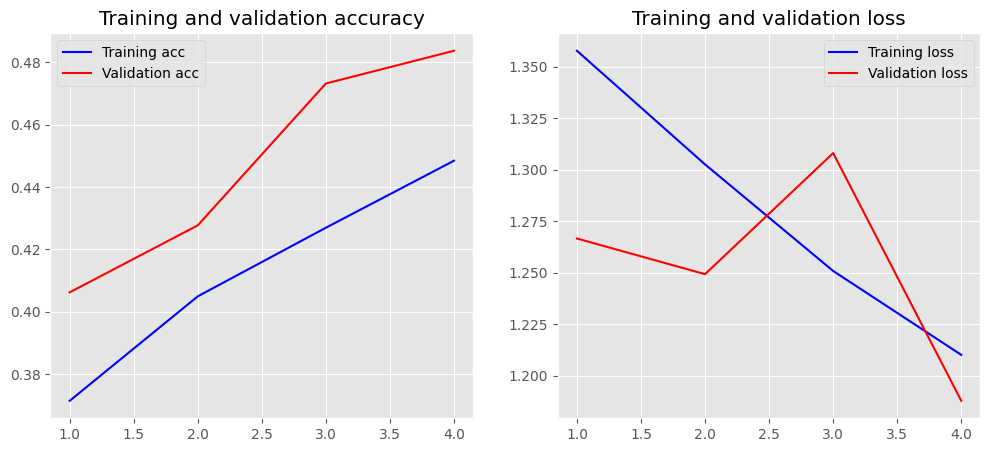

In [126]:
plot_history(rmm)

63/63 [==============================] - 7s 100ms/step


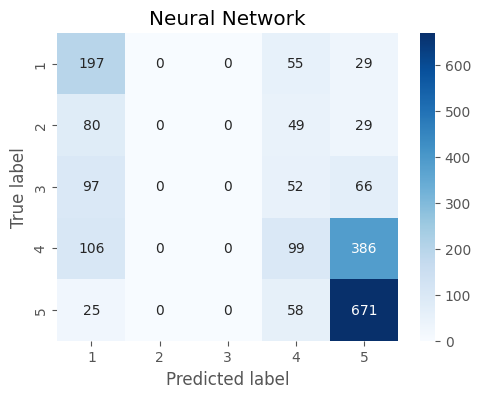

In [128]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = rnn_model2.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
plt.title("Neural Network")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [129]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]
test_indexes = sentences_test.index


In [139]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

32/32 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.14      1.00      0.25       281
           1       0.00      0.00      0.00       158
           2       0.00      0.00      0.00       215
           3       0.30      0.01      0.01       591
           4       0.00      0.00      0.00       754

    accuracy                           0.14      1999
   macro avg       0.09      0.20      0.05      1999
weighted avg       0.11      0.14      0.04      1999



/Users/yashvipipaliya/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yashvipipaliya/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yashvipipaliya/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [132]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
436417,3.0,i honestly cant tell the difference from my old chord and this new one. i guess it looks nice bu...,"[honestly, cant, tell, difference, old, chord, new, one, guess, look, nice, nt, hear, difference...",1,2.0
327615,3.0,"Mic works as hoped, but noticed some scuffing on the outside cover mic sleeve that shouldn't be ...","[mic, work, hop, notice, scuff, outside, cover, mic, sleeve, nt, box, look, little, rough]",1,2.0
915573,5.0,Fantastic versatility functionality and audio quality. 16 x 16. No need for an audio interface. ...,"[fantastic, versatility, functionality, audio, quality, sixteen, x, sixteen, need, audio, interf...",5,0.0
957781,5.0,Awesome product and service!,"[awesome, product, service]",5,0.0
421249,4.0,"Tambourine is well built. Large handle. The smell is not good, as another reviewer stated. It st...","[tambourine, well, build, large, handle, smell, good, another, reviewer, state, stink, smell, nt...",1,3.0
1337799,1.0,"The microphone sounded good, but there was radio interference in the PA system after we hooked u...","[microphone, sound, good, radio, interference, pa, system, hook, microphone, along, change, make...",1,0.0
811191,3.0,The cable seems to be of high quality. However if you don't use it for a while it cracks and cra...,"[cable, seem, high, quality, however, nt, use, crack, crackle, additionally, lifetime, cable, ev...",1,2.0
283060,4.0,"We received this system several weeks ago. when we received it, the microphone levels were not c...","[receive, system, several, weeks, ago, receive, microphone, level, compatible, one, bassy, sound...",1,3.0
47289,5.0,love it,[love],5,0.0
1028081,5.0,"Solid shock mount rack unit. foam is good quality, I don't foresee any compression due to weight...","[solid, shock, mount, rack, unit, foam, good, quality, nt, foresee, compression, due, weight, fu...",5,0.0


In [133]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    967
1.0    576
2.0    212
3.0    190
4.0     54
dtype: int64

# LSTM

In [165]:
from keras.layers import Dropout
from keras.layers import BatchNormalization

lstm_model = Sequential()
lstm_model.add(layers.Embedding(vocab_size, output_dim=embedding_dim, input_length=maxlen))
lstm_model.add(layers.LSTM(264, activation='relu', return_sequences=True))
lstm_model.add(BatchNormalization())  
lstm_model.add(layers.LSTM(128, activation='relu'))
lstm_model.add(BatchNormalization())  
lstm_model.add(layers.Dense(128, activation='relu'))
lstm_model.add(BatchNormalization())  # Add Batch Normalization
lstm_model.add(layers.Dense(5, activation='sigmoid'))  
lstm_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [169]:
start_time = datetime.now()
lstm_history = lstm_model.fit(X_train, y_train,
                               epochs= 2,
                               verbose=1,
                               validation_data=(X_test, y_test),
                               batch_size=264
                               )
end_time = datetime.now()


Epoch 1/2
31/31 [==============================] - 715s 23s/step - loss: 1.5845 - accuracy: 0.3814 - val_loss: 1.5809 - val_accuracy: 0.3772
Epoch 2/2
31/31 [==============================] - 995s 32s/step - loss: 1.5729 - accuracy: 0.3814 - val_loss: 1.5683 - val_accuracy: 0.3772


In [170]:
loss, accuracy = lstm_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.3814
Testing Accuracy:  0.3772


In [ ]:
import seaborn as sns

predictions = model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1)) 

cm_df = pd.DataFrame(cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt = 'g', cmap = 'Blues')
plt.title("Neural Network")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

loss_trn, accuracy_trn = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_trn))
loss_test, accuracy_test = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

In [233]:
pred_stars = predictions.argmax(axis = 1).tolist()
pred_stars = [x+1 for x in pred_stars]
pred_stars[0:4]
test_indexes = sentences_test.index


In [234]:
from sklearn.metrics import classification_report

y_test_norm = y_test.argmax(axis = 1)
y_test_norm

predictions = model.predict(X_test, batch_size = 64, verbose = 1)
y_pred = np.argmax(predictions, axis = 1)
y_pred

print(classification_report(y_test_norm, y_pred))

63/63 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       553
           1       0.21      0.16      0.18       310
           2       0.26      0.29      0.28       475
           3       0.40      0.44      0.42      1108
           4       0.63      0.58      0.60      1552

    accuracy                           0.47      3998
   macro avg       0.40      0.40      0.40      3998
weighted avg       0.47      0.47      0.47      3998



In [235]:
pd.options.display.max_colwidth = 100

sample_df_test = sample.loc[test_indexes]
sample_df_test['pred_stars'] = pred_stars

sample_df_test['diff_pred'] = abs(sample_df_test['pred_stars'] - pd.to_numeric(sample_df_test.overall))

sample_df_test = sample_df_test.sort_values(by = ['diff_pred'], ascending = False)

sample_df_test = sample_df_test.filter(['overall', 'reviewText', 'tokens', 'pred_stars', 'diff_pred'])
sample_df_test.head(10)

,overall,reviewText,tokens,pred_stars,diff_pred
557011,5.0,Mod-9eb2c1b Reverb tank for nashville 112 or nashville 400 peavey guitar amp . Good mod better ...,"[mod9eb2c1b, reverb, tank, nashville, one hundred and twelve, nashville, four hundred, peavey, g...",1,4.0
1399290,1.0,"This cheap little phaser has some good sounds, but it imparts undesirable clipping to my sound. ...","[cheap, little, phaser, good, sound, impart, undesirable, clip, sound, find, anything, prevent, ...",5,4.0
1330608,1.0,"For $40, you can almost cover 1/3"" of your tripod! The illusion is immediately lost as soon as y...","[forty, almost, cover, thirteen, tripod, illusion, immediately, lose, soon, move, one, center, r...",5,4.0
546354,1.0,I bought this acoustic pickup 4 weeks ago. I've used it twice and I'm very careful with how I co...,"[buy, acoustic, pickup, four, weeks, ago, ve, use, twice, m, careful, coil, cable, put, much, be...",5,4.0
1208725,1.0,Does not support the weight suppose to,"[support, weight, suppose]",5,4.0
939871,5.0,"Just received it and checked my tracking force for my AT-LP 120 with my Shure 97Xe, tracking for...","[receive, check, track, force, atlp, one hundred and twenty, shure, 97xe, track, force, one, gra...",1,4.0
690850,1.0,"Well, well, well! This is my second review on this keyboard. First let me say that my first revi...","[well, well, well, second, review, keyboard, first, let, say, first, review, block, amazon, cuz,...",5,4.0
256316,5.0,I've been using this juice in my foggers for years with my Hallowe'en display. Does not disappo...,"[ve, use, juice, foggers, years, halloween, display, disappoint, remember, cool, fog, wind, alwa...",1,4.0
657632,1.0,"There was a 3 in cut in the top compartment of the gig bag, and I didn't expect it to have plast...","[three, cut, top, compartment, gig, bag, nt, expect, plastic, zipper, usually, nt, hold, well]",5,4.0
765031,1.0,All picks are Guitar Picks for Girls!\nThese work just as well when used by boys (I'm assuming t...,"[pick, guitar, pick, girls, work, well, use, boys, m, assume, nt, cause, sex, change, spontaneou...",5,4.0


In [236]:
sample_df_test.groupby(['diff_pred']).size()

diff_pred
0.0    1865
1.0    1390
2.0     434
3.0     199
4.0     110
dtype: int64